In [1]:
from algorithm import *
from model import *
import torch
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix
import pickle
from netrd.distance import netsimile
import networkx as nx
import os.path as osp
from scipy.sparse import coo_matrix
from tqdm import tqdm
import random
import warnings
from torch.optim import Adam
from utils import *
import argparse
warnings.filterwarnings("ignore")

In [2]:
# import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import pandas as pd

In [3]:
def load_adj(dataset):
    if (dataset == "celegans"):
        S = torch.load("data/celegans.pt")
    elif(dataset == "arenas"):
        S = torch.load("data/arenas.pt")
    elif (dataset == "douban"):
        S = torch.load("data/douban.pt")
    elif(dataset == "Online"):
        S = torch.load("data/online.pt")
    elif(dataset == "Offline"):
        S = torch.load("data/offline.pt")
    elif (dataset == "ACM"):
        S = torch.load("data/ACM.pt")
    elif (dataset == "DBLP"):
        S = torch.load("data/DBLP.pt")
    else:
        filepath = "data/" + dataset + ".npz"
        loader = load_npz(filepath)
        data = loader["adj_matrix"]
        samples = data.shape[0]
        features = data.shape[1]
        values = data.data
        coo_data = data.tocoo()
        indices = torch.LongTensor([coo_data.row, coo_data.col])
        S = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features]).to_dense()
        if (not torch.all(S.transpose(0, 1) == S)):
            S = torch.add(S, S.transpose(0, 1))
        S = S.int()
        ones = torch.ones_like(S)
        S = torch.where(S > 1, ones, S)
    return S

In [4]:
dataset_ = "celegans"
model_ = "uniform"
level_ = 0.0

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
train_set = ["celegans","arenas","douban","cora"]
test_set = [dataset_]
probability_model = model_
training_perturbation_level = level_
no_training_samples_per_graph = 10 # change 10
NUM_HIDDEN_LAYERS = 8
HIDDEN_DIM = 16
output_feature_size = 8 # embedding size
lr = 0.001
epoch = 100

In [5]:
print("Loading training datasets")

train_loader = {}
original_graph_loader = {}
for dataset in [*set(train_set + test_set)]:
    original_graph_loader[dataset] = load_adj(dataset)

Loading training datasets


In [6]:
temp = original_graph_loader[dataset_]
print(temp.shape)
temp

torch.Size([453, 453])


tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
edge_index = temp.nonzero().t().contiguous()
edge_index

tensor([[  0,   0,   0,  ..., 450, 451, 452],
        [  1,   2,   3,  ..., 449, 107, 443]])

In [8]:
print("Generating training perturbations")
print(train_set)
for dataset in train_set:
    train_loader[dataset] = generate_purturbations(device, original_graph_loader[dataset],
                                                    perturbation_level = training_perturbation_level,
                                                    no_samples=no_training_samples_per_graph,
                                                    method = probability_model)

Generating training perturbations
['celegans', 'arenas', 'douban', 'cora']


In [9]:
temp = train_loader[dataset_]
print(len(temp), temp[0].shape)
temp[0]

10 torch.Size([453, 453])


tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [10]:
edge_index = temp[0].nonzero().t().contiguous()
edge_index

tensor([[  0,   0,   0,  ..., 450, 451, 452],
        [  1,   2,   3,  ..., 449, 107, 443]])

In [11]:
model = GAE(NUM_HIDDEN_LAYERS,
            7,
            HIDDEN_DIM,
            output_feature_size, activation=F.relu,
            use_input_augmentation=True,
            use_output_augmentation=False,
            encoder="GIN",variational=False).to(device)

In [12]:
print("Generating training features")
train_features = {}
for dataset in train_loader.keys():
    train_features[dataset] = generate_features(train_loader[dataset])

Generating training features


In [13]:
temp = train_features[dataset_]
print(len(temp), temp[0].shape)
temp[0]

10 torch.Size([453, 7])


tensor([[7.0000e+00, 7.1429e-01, 7.4571e+01,  ..., 2.2000e+01, 4.8500e+02,
         2.7600e+02],
        [1.1000e+01, 6.5455e-01, 6.7091e+01,  ..., 4.7000e+01, 6.5500e+02,
         3.1800e+02],
        [2.3700e+02, 3.1109e-02, 1.1300e+01,  ..., 1.1070e+03, 7.0100e+02,
         1.9300e+02],
        ...,
        [2.0000e+00, 1.0000e+00, 6.0000e+00,  ..., 3.0000e+00, 8.0000e+00,
         8.0000e+00],
        [1.0000e+00, 0.0000e+00, 2.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 0.0000e+00, 4.0000e+00,  ..., 1.0000e+00, 3.0000e+00,
         3.0000e+00]])

In [14]:
print("Fitting T-GAE")
# fit_GAE(len(train_set)*(no_training_samples_per_graph+1),model,epoch, train_loader, train_features, device, lr, args.level, args.dataset, args.model)
no_samples = len(train_set) * (no_training_samples_per_graph + 1)
GAE = model
level_eval = level_
dataset_eval = dataset_
model_eval = model_

best_avg = 0
best_std = 0
S_hat_samples, S_prime_samples, p_samples = gen_test_set(device, load_adj(dataset_eval), 10,
                                                            [level_eval],
                                                            method=model_eval)
S_eval = load_adj(dataset_eval) # Adjency matrix of S
adj_S = coo_matrix(S_eval.numpy())
adj_norm_S = preprocess_graph(adj_S)
adj_norm_S = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_S[0].T),
                                    torch.FloatTensor(adj_norm_S[1]),
                                    torch.Size(adj_norm_S[2])).to(device)

S_feat = generate_features([S_eval])[0] # Features matrix of S

S_hat_features = generate_features(S_hat_samples[str(level_eval)])
optimizer = Adam(GAE.parameters(), lr=lr,weight_decay=5e-4)

for step in range(epoch):
    loss = 0
    for dataset in train_loader.keys():
        S = train_loader[dataset][0]
        initial_features = train_features[dataset]
        for i in range(len(train_loader[dataset])):
            adj_tensor = train_loader[dataset][i]
            adj = coo_matrix(adj_tensor.numpy())
            adj_norm = preprocess_graph(adj)
            pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
            norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

            adj_label = coo_matrix(S.numpy())
            adj_label = sparse_to_tuple(adj_label)

            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T),
                                                torch.FloatTensor(adj_norm[1]),
                                                torch.Size(adj_norm[2])).to(device)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T),
                                                torch.FloatTensor(adj_label[1]),
                                                torch.Size(adj_label[2])).to(device)

            initial_feature = initial_features[i].to(device)

            weight_mask = adj_label.to_dense().view(-1) == 1
            weight_tensor = torch.ones(weight_mask.size(0))
            weight_tensor[weight_mask] = pos_weight
            weight_tensor = weight_tensor.to(device)
            z = GAE(initial_feature, adj_norm)
            A_pred = torch.sigmoid(torch.matmul(z, z.t()))
            loss += norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1),
                                                        weight=weight_tensor)
    optimizer.zero_grad()
    loss = loss / no_samples
    loss.backward()
    optimizer.step()
    print("Epoch:", '%04d' % (step + 1), "train_loss= {0:.5f}".format(loss.item()), end = " ")
    
    S_emb = GAE(S_feat.to(device), adj_norm_S).detach()
    avg, std, indices_match = test_matching(GAE, S_hat_samples[str(level_eval)], p_samples[str(level_eval)], 
                            S_hat_features, S_emb, device, metric="accuracy")
    
    if(avg > best_avg):
        best_avg = avg
        best_std = std
    print("Current best result:" +str(best_avg)[:6]+"+-"+str(best_std)[:5])

print(0, level_eval)
print("---")
x = S_hat_samples[str(level_eval)]
print(1, type(x), len(x), x[0].shape)
print("---")
x = p_samples[str(level_eval)]
print(2, type(x), len(x), x[0].shape)
print(indices_match)

Fitting T-GAE
Epoch: 0001 train_loss= 42.46659 Correct number of matchings is 0.8880+-0.0111

Current best result:0.8880+-0.011
Epoch: 0002 train_loss= 40.24141 

Correct number of matchings is 0.8900+-0.0145

Current best result:0.8900+-0.014
Epoch: 0003 train_loss= 36.49289 Correct number of matchings is 0.8878+-0.0129

Current best result:0.8900+-0.014
Epoch: 0004 train_loss= 31.64669 Correct number of matchings is 0.8927+-0.0116

Current best result:0.8927+-0.011
Epoch: 0005 train_loss= 26.93011 Correct number of matchings is 0.8931+-0.0106

Current best result:0.8931+-0.010
Epoch: 0006 train_loss= 23.42901 Correct number of matchings is 0.8916+-0.0128

Current best result:0.8931+-0.010
Epoch: 0007 train_loss= 22.14172 Correct number of matchings is 0.8918+-0.0131

Current best result:0.8931+-0.010
Epoch: 0008 train_loss= 20.81928 Correct number of matchings is 0.8883+-0.0108

Current best result:0.8931+-0.010
Epoch: 0009 train_loss= 21.55520 Correct number of matchings is 0.8905+-0.0145

Current best result:0.8931+-0.010
Epoch: 0010 train_loss= 19.99323 Correct number of matchings is 0.8911+-0.0139

Current best result:0.8931+-0.010
Epoch: 

### Test

In [15]:
# test save matrix

""" # save
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
torch.save(x, 'data/A.pt')

# load
print(dataset_eval)
# S_eval = load_adj(dataset_eval)
S_eval = torch.load("data/A.pt")
print(S_eval.shape)
S_eval """

' # save\nx = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])\ntorch.save(x, \'data/A.pt\')\n\n# load\nprint(dataset_eval)\n# S_eval = load_adj(dataset_eval)\nS_eval = torch.load("data/A.pt")\nprint(S_eval.shape)\nS_eval '

In [16]:
print(indices_match)
for k, item in enumerate(indices_match):
    print(k, len(item), item)

[[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 136, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 24

#### Test

In [17]:
# adj_norm_S, G1

adj_norm_S

tensor(indices=tensor([[  0,   1,   2,  ..., 451, 443, 452],
                       [  0,   0,   0,  ..., 451, 452, 452]]),
       values=tensor([0.1250, 0.1021, 0.0229,  ..., 0.5000, 0.3162, 0.5000]),
       device='cuda:0', size=(453, 453), nnz=4503, layout=torch.sparse_coo)

In [18]:
# Features matrix of S

S_feat

tensor([[7.0000e+00, 7.1429e-01, 7.4571e+01,  ..., 2.2000e+01, 4.8500e+02,
         2.7600e+02],
        [1.1000e+01, 6.5455e-01, 6.7091e+01,  ..., 4.7000e+01, 6.5500e+02,
         3.1800e+02],
        [2.3700e+02, 3.1109e-02, 1.1300e+01,  ..., 1.1070e+03, 7.0100e+02,
         1.9300e+02],
        ...,
        [2.0000e+00, 1.0000e+00, 6.0000e+00,  ..., 3.0000e+00, 8.0000e+00,
         8.0000e+00],
        [1.0000e+00, 0.0000e+00, 2.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 0.0000e+00, 4.0000e+00,  ..., 1.0000e+00, 3.0000e+00,
         3.0000e+00]])

In [19]:
# adj_norm_S_hat, G2

S_hat_cur = S_hat_samples[str(level_eval)][0]
adj = coo_matrix(S_hat_cur.numpy())
adj_norm_S_hat = preprocess_graph(adj)
adj_norm_S_hat = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_S_hat[0].T),
                                    torch.FloatTensor(adj_norm_S_hat[1]),
                                    torch.Size(adj_norm_S_hat[2])).to(device)
adj_norm_S_hat

tensor(indices=tensor([[  0,  27, 111,  ..., 309, 437, 452],
                       [  0,   0,   0,  ..., 452, 452, 452]]),
       values=tensor([0.1667, 0.1543, 0.0870,  ..., 0.0630, 0.0434, 0.1429]),
       device='cuda:0', size=(453, 453), nnz=4503, layout=torch.sparse_coo)

In [20]:
S_hat_feat = S_hat_features[0].to(device)
S_hat_feat

tensor([[  5.0000,   0.7000,   9.4000,  ...,  12.0000,  28.0000,  26.0000],
        [  3.0000,   1.0000, 132.6667,  ...,   6.0000, 389.0000, 299.0000],
        [  4.0000,   0.8333,   7.0000,  ...,   9.0000,  14.0000,  10.0000],
        ...,
        [  1.0000,   0.0000,   4.0000,  ...,   1.0000,   3.0000,   3.0000],
        [  3.0000,   1.0000, 117.3333,  ...,   6.0000, 343.0000, 275.0000],
        [  6.0000,   0.5333,  32.5000,  ...,  14.0000, 173.0000,  89.0000]],
       device='cuda:0')

In [21]:
# 
# z1 = GAE(S_feat, adj_norm_S).detach()
# z2 = GAE(S_hat_feat, adj_norm_S_hat).detach()
# D = torch.cdist(z1, z2, p=2) # distance matrix

z = GAE(S_hat_feat, adj_norm_S_hat).detach()
D = torch.cdist(S_emb, z, p=2) # distance matrix
print(D.shape)
D

torch.Size([453, 453])


tensor([[ 5.4664,  6.3334,  4.4241,  ...,  5.2579,  5.3074,  5.0122],
        [ 7.0269,  8.4434,  6.4429,  ...,  6.9339,  7.0671,  7.0446],
        [55.3510, 50.3567, 55.0811,  ..., 55.4781, 50.8772, 55.2648],
        ...,
        [ 1.4445,  7.9764,  1.8972,  ...,  1.3562,  6.4667,  2.0190],
        [ 1.7421,  7.2007,  1.5310,  ...,  1.0176,  5.9281,  2.2484],
        [ 1.3870,  7.7416,  1.2251,  ...,  0.0000,  6.4855,  2.0272]],
       device='cuda:0')

#### Graphs

torch.Size([2, 4503])
tensor([[  0,   0,   0,  ..., 451, 452, 452],
        [  0,   1,   2,  ..., 451, 443, 452]], device='cuda:0')
453 2025


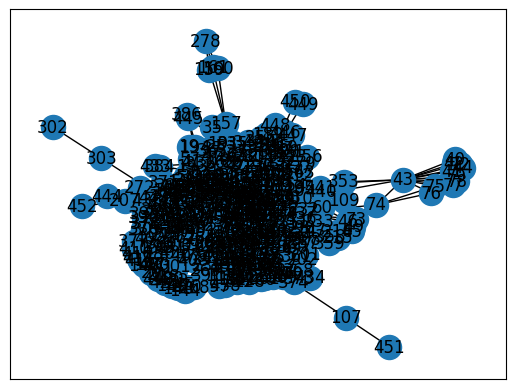

In [22]:

temp = adj_norm_S.coalesce().indices()
print(temp.shape)
print(temp)

G1 = nx.from_edgelist(temp.T.cpu().numpy())
G1.remove_edges_from(nx.selfloop_edges(G1))
print(G1.number_of_nodes(), G1.number_of_edges())

pos = nx.spring_layout(G1)
nx.draw_networkx(G1, pos=pos)

torch.Size([2, 4503])
tensor([[  0,   0,   0,  ..., 452, 452, 452],
        [  0,  27, 111,  ..., 309, 437, 452]], device='cuda:0')
453 2025


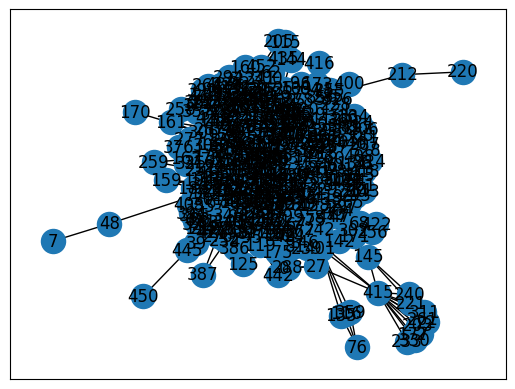

In [23]:
temp = adj_norm_S_hat.coalesce().indices()
print(temp.shape)
print(temp)

G2 = nx.from_edgelist(temp.T.cpu().numpy())
G2.remove_edges_from(nx.selfloop_edges(G2))
print(G2.number_of_nodes(), G2.number_of_edges())

nx.draw_networkx(G2)

In [24]:
print(indices_match[-1])
print(len(indices_match))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 242, 243,

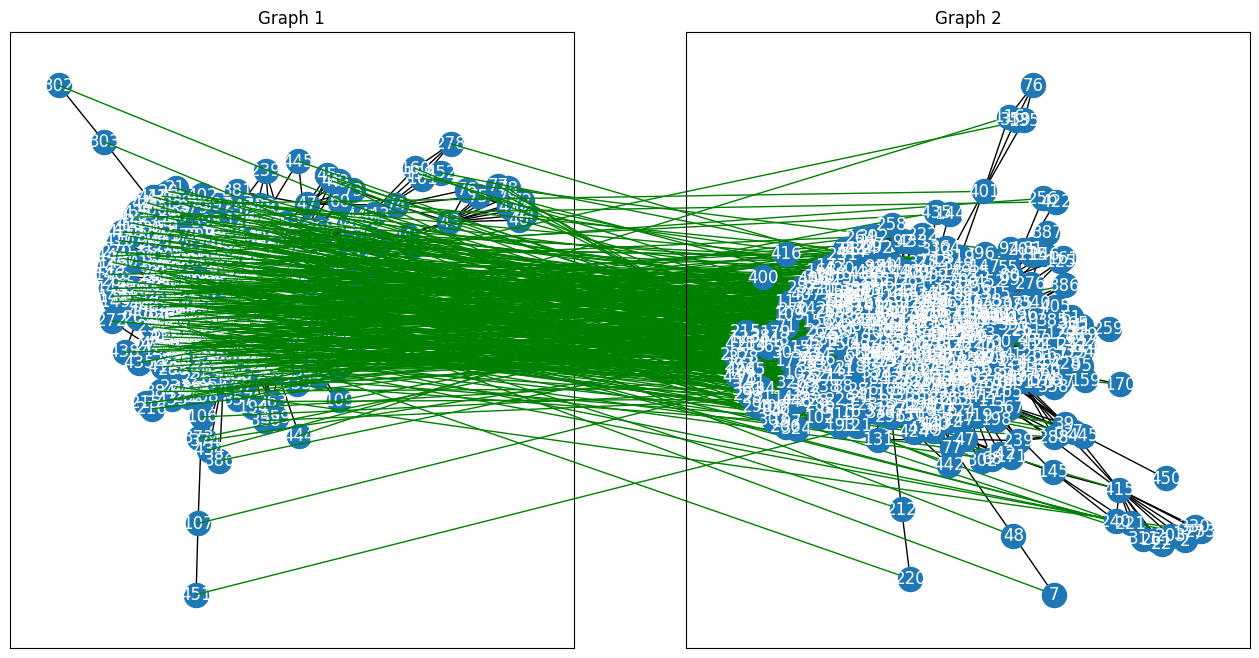

In [25]:
pos1 = nx.spring_layout(G1)
pos2 = nx.spring_layout(G2)

plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 2, 1)
plt.title("Graph 1")
nx.draw_networkx(G1, pos=pos1, font_color="w")
ax2 = plt.subplot(1, 2, 2)
plt.title("Graph 2")
nx.draw_networkx(G2, pos=pos2, font_color="w")

# add connections
for i in indices_match[-1]:
    con = ConnectionPatch(xyA=pos1[i], xyB=pos2[i], coordsA=ax1.transData, coordsB=ax2.transData, arrowstyle="-", color="green")
    ax2.add_artist(con)
plt.show()

In [26]:
print(indices_match[-1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 242, 243,

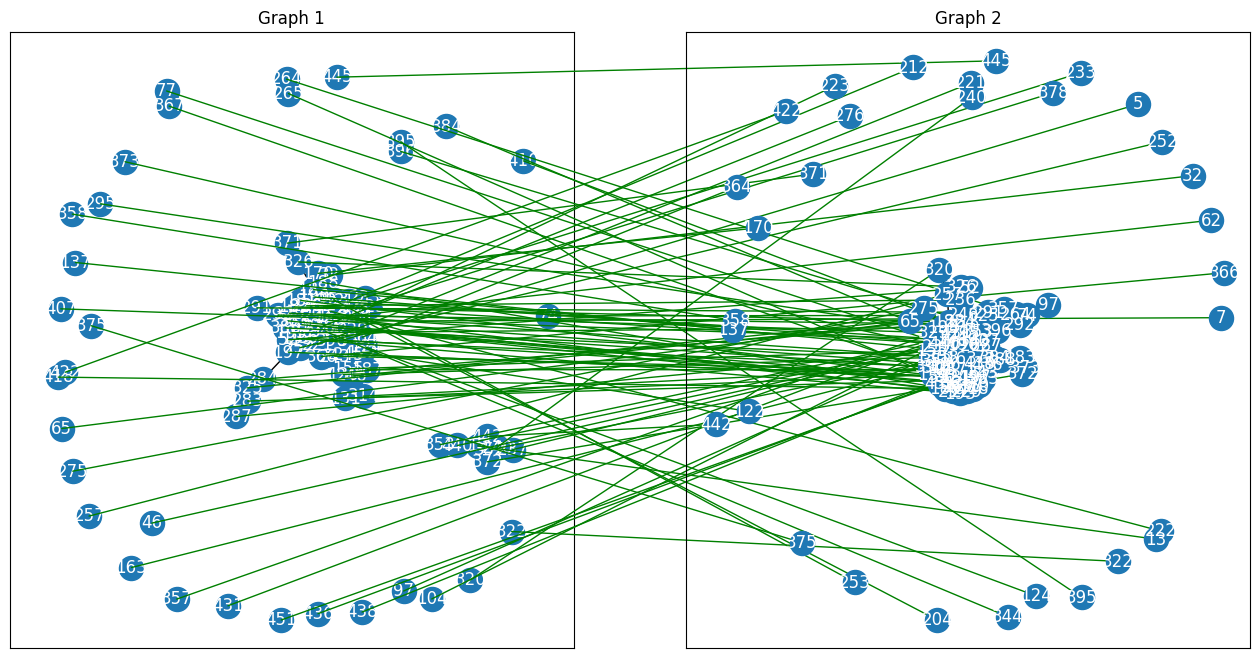

In [31]:
import random

nodes_id = indices_match[-1].copy()
random.shuffle(nodes_id)
nodes_id = nodes_id[:100]

SG1 = G1.subgraph(nodes_id)
SG2 = G2.subgraph(nodes_id)

pos1 = nx.spring_layout(SG1)
pos2 = nx.spring_layout(SG2)

plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 2, 1)
plt.title("Graph 1")
nx.draw_networkx(SG1, pos=pos1, font_color="w")
ax2 = plt.subplot(1, 2, 2)
plt.title("Graph 2")
nx.draw_networkx(SG2, pos=pos2, font_color="w")

# add connections
for i in nodes_id:
    con = ConnectionPatch(xyA=pos1[i], xyB=pos2[i], coordsA=ax1.transData, coordsB=ax2.transData, arrowstyle="-", color="green")
    ax2.add_artist(con)
plt.show()

#### Option 0

In [ ]:
X = get_match(D, device)
print(X.shape)
X

torch.Size([453, 453])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
option0 = matrix_to_edge(X)
option0

(453, 2)


array([[ 52,   0],
       [303,   1],
       [129,   2],
       [302,   3],
       [232,   4],
       [433,   5],
       [174,   6],
       [430,   7],
       [396,   8],
       [ 96,   9],
       [322,  10],
       [  2,  11],
       [206,  12],
       [390,  13],
       [ 93,  14],
       [161,  15],
       [431,  16],
       [290,  17],
       [ 23,  18],
       [450,  19],
       [144,  20],
       [344,  21],
       [423,  22],
       [295,  23],
       [315,  24],
       [425,  25],
       [ 73,  26],
       [254,  27],
       [259,  28],
       [414,  29],
       [323,  30],
       [270,  31],
       [134,  32],
       [164,  33],
       [ 28,  34],
       [420,  35],
       [180,  36],
       [378,  37],
       [329,  38],
       [386,  39],
       [389,  40],
       [242,  41],
       [397,  42],
       [438,  43],
       [334,  44],
       [ 74,  45],
       [208,  46],
       [ 95,  47],
       [228,  48],
       [167,  49],
       [ 68,  50],
       [340,  51],
       [331,

In [ ]:
df_match = pd.DataFrame(option0)
df_match.columns = ["g1", "g2"]
df_match

df_match[df_match["g1"] == df_match["g2"]]

,g1,g2
123,123,123
230,230,230
417,417,417


#### Option 1

In [28]:
total_cost, assignments = hungarian_algorithm(D.cpu())

In [29]:
option1 = np.array(assignments)
option1 = option1[option1[:, 1].argsort()]
print(option1.shape)
option1

(453, 2)


array([[440,   0],
       [345,   1],
       [ 40,   2],
       [221,   3],
       [312,   4],
       [433,   5],
       [305,   6],
       [451,   7],
       [436,   8],
       [385,   9],
       [ 58,  10],
       [183,  11],
       [231,  12],
       [227,  13],
       [427,  14],
       [ 29,  15],
       [414,  16],
       [318,  17],
       [ 69,  18],
       [137,  19],
       [165,  20],
       [251,  21],
       [ 79,  22],
       [212,  23],
       [265,  24],
       [ 98,  25],
       [166,  26],
       [353,  27],
       [230,  28],
       [ 48,  29],
       [ 18,  30],
       [277,  31],
       [ 36,  32],
       [ 91,  33],
       [168,  34],
       [425,  35],
       [400,  36],
       [388,  37],
       [  0,  38],
       [442,  39],
       [ 17,  40],
       [316,  41],
       [181,  42],
       [ 95,  43],
       [ 85,  44],
       [375,  45],
       [208,  46],
       [ 47,  47],
       [107,  48],
       [206,  49],
       [164,  50],
       [ 34,  51],
       [328,

In [30]:
df_match = pd.DataFrame(option1)
df_match.columns = ["g1", "g2"]
df_match

df_match[df_match["g1"] == df_match["g2"]]

,g1,g2
47,47,47


#### Option 2

In [ ]:
import pygmtools as pygm

X = pygm.hungarian(D.cpu().numpy())
print(X.shape)
X

In [ ]:
option2 = matrix_to_edge(X)
option2

In [ ]:
""" matching = test_matching(truth, option2)
print(len(matching))
print(len(matching) / len(truth))
matching """

In [ ]:
df_match = pd.DataFrame(option2)
df_match.columns = ["g1", "g2"]
df_match

df_match[df_match["g1"] == df_match["g2"]]

#### Option 3

In [ ]:
indices = []
for i in range(D.shape[0]):
	dist_list = D[i]
	sorted_neighbors = torch.argsort(dist_list).cpu()
	indices.append([i, sorted_neighbors[0]])

option3 = np.array(indices)
option3 = option3[option3[:, 1].argsort()]
print(option3.shape)
option3

In [ ]:
df_match = pd.DataFrame(option3)
df_match.columns = ["g1", "g2"]
df_match

df_match[df_match["g1"] == df_match["g2"]]

#### Option 4

In [ ]:
X = greedy_match(D)
X = X.todense()
X = np.array(X)
print(X.shape)
print(X)

In [ ]:
option4 = matrix_to_edge(X)
option4

In [ ]:
df_match = pd.DataFrame(option4)
df_match.columns = ["g1", "g2"]
df_match

df_match[df_match["g1"] == df_match["g2"]]

#### Option 5

In [ ]:
D_ = complete_to_square(D.cpu(), pad_value=100.0)
print(D_.shape)
D_

In [ ]:
X = get_match(torch.tensor(D_), device)
print(X.shape)
X

In [ ]:
option5 = matrix_to_edge(X)
option5

In [ ]:
df_match = pd.DataFrame(option5)
df_match.columns = ["g1", "g2"]
df_match

df_match[df_match["g1"] == df_match["g2"]]

---